In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from sklearn.metrics import mean_absolute_error

In [23]:
df = pd.read_csv("../data/icecore.csv")
df["const"] = 1
df.head()

,depth_m,temp_diff_c,co2_ppmv,const
0,3304,0.94,277.6,1
1,3301,1.43,286.9,1
2,3299,1.32,285.5,1
3,3293,1.08,276.3,1
4,3289,1.27,283.7,1


In [24]:
y = df["temp_diff_c"].to_numpy()
X = df[["co2_ppmv", "const"]].to_numpy()
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     743.8
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           1.06e-89
Time:                        21:18:00   Log-Likelihood:                -719.12
No. Observations:                 363   AIC:                             1442.
Df Residuals:                     361   BIC:                             1450.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0885      0.003     27.273      0.000       0.082       0.095
const        -24.8765      0.759    -32.763      0.000     -26.370     -23.383
==============================================================================
Omnibus:                        0.032   Durbin-Watson:                   0.467
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.055
Skew:                          -0.022   Prob(JB):                        0.973
Kurtosis:                       2.960   Cond. No.                     1.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
adf_rt = tsa.adfuller(y)
print(f"ADF statistic：{adf_rt[0]}")
print(f"P-value：{adf_rt[1]}")
print(f"Critival Value：{adf_rt[4]}")

adf_rt = tsa.adfuller(X[:, 0])
print(f"ADF statistic：{adf_rt[0]}")
print(f"P-value：{adf_rt[1]}")
print(f"Critival Value：{adf_rt[4]}")

ADF statistic：-4.298020789233497
P-value：0.0004477310847749258
Critival Value：{'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}
ADF statistic：-2.8996884614108174
P-value：0.045384237166945195
Critival Value：{'1%': -3.4485948978753314, '5%': -2.86957971128312, '10%': -2.571053050314224}


### OLS

MAE：1.4105631655436424


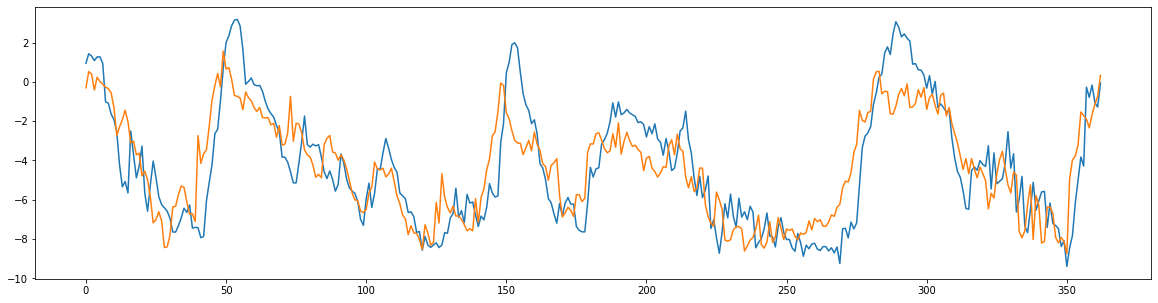

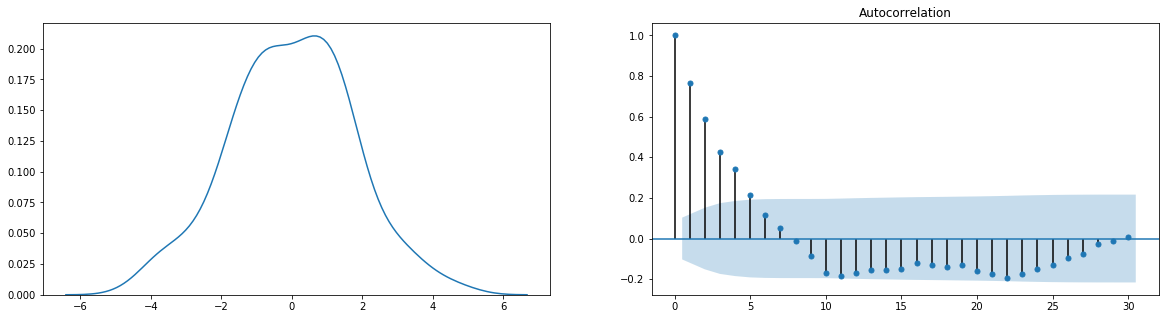

In [99]:
y_pred = model.predict(X)
res = y - y_pred
print(f"MAE：{mean_absolute_error(y, y_pred)}")

fig = plt.figure(figsize=(20, 5))
x = np.arange(len(y))
ax = fig.add_subplot(111)
sns.lineplot(x, y, ax=ax)
sns.lineplot(x, y_pred, ax=ax)
fig = plt.figure(figsize=(20, 5))
sns.kdeplot(res, ax=fig.add_subplot(121))
sm.graphics.tsa.plot_acf(res, lags=30, ax=fig.add_subplot(122));

### GLS

In [95]:
model = sm.OLS(y, X).fit()
y_pred = model.predict(X)
res = y - y_pred

# 1時点先の残差を予測する
res_t, res_t1 = res[:-1], res[1:]
model_res = sm.OLS(res_t, res_t1).fit()
coef = model_res.params[0] # 回帰係数の取り出し

# 残差予測モデルの回帰係数を使ってyやXを修正
y_star = np.append(np.sqrt(1-coef**2)*y[0], y[:-1]-coef*y[1:])
X_star = np.append(np.sqrt(1-coef**2)*X[0, 0], X[1:, :-1]-coef*X[1:, 1:])
const_star = np.append(np.sqrt(1-coef**2), [1-coef]*(len(y)-1))
X_star = np.array([X_star, const_star]).T

model_star = sm.OLS(y_star, X_star).fit()
y_pred_star = model_star.predict(X_star)
model_star.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.489
Model:                            OLS   Adj. R-squared (uncentered):              0.486
Method:                 Least Squares   F-statistic:                              172.9
Date:                Mon, 02 Jan 2023   Prob (F-statistic):                    2.13e-53
Time:                        23:15:12   Log-Likelihood:                         -531.25
No. Observations:                 363   AIC:                                      1066.
Df Residuals:                     361   BIC:                                      1074.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0067      0.001      4.515      0.000       0.004       0.010
x2           -10.7729      1.471     -7.325      0.000     -13.665      -7.880
==============================================================================
Omnibus:                       47.470   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.430
Skew:                           0.511   Prob(JB):                     5.95e-38
Kurtosis:                       6.207   Cond. No.                     6.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAE：0.8107621640446774


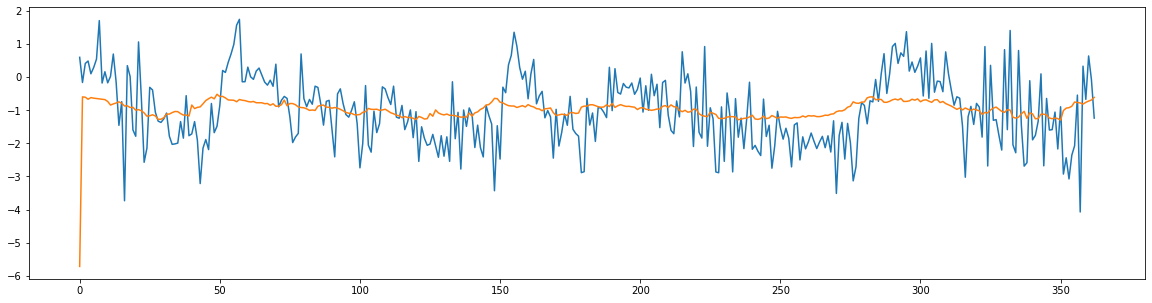

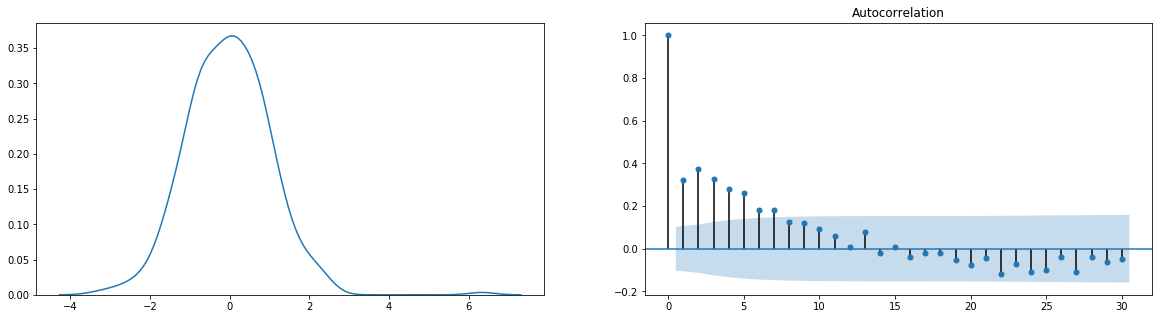

In [100]:
res = y_star - y_pred_star
print(f"MAE：{mean_absolute_error(y_star, y_pred_star)}")

fig = plt.figure(figsize=(20, 5))
x = np.arange(len(y_star))
ax = fig.add_subplot(111)
sns.lineplot(x, y_star, ax=ax)
sns.lineplot(x, y_pred_star, ax=ax)
fig = plt.figure(figsize=(20, 5))
sns.kdeplot(res, ax=fig.add_subplot(121))
sm.graphics.tsa.plot_acf(res, lags=30, ax=fig.add_subplot(122));